<a href="https://colab.research.google.com/github/JesseTNRoberts/Do-Language-Models-Have-Rational-Preference/blob/main/Population_Prisoners_Dilemma_Preference_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas._libs.lib import is_timedelta_or_timedelta64_array
import pandas as pd
import plotly.graph_objects as go
!pip install researchpy
import researchpy as rp
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

# !pip install nbformat --upgrade
# !pip install seaborn --upgrade

In [3]:
# Assuming your CSV file is named "data.csv"
from google.colab import drive
drive.mount('/content/drive')
loc = "/content/drive/MyDrive/Data/"

models = [
          # 'distilbert-base-uncased',
          # 'bert-base-uncased',
          # 'bert-large-uncased',
          # 'roberta-base',
          # 'roberta-large',
          # 'xlm-roberta-large',
          # 'electra-large-generator',
          # 'openai-gpt', 'distilgpt2',
          # 'gpt2',
          # 'gpt2-medium',
          # 'open_llama_13b',
          'llama-2-7b',
          # 'llama-2-13b',
          # 'alpaca-7b',
          'Mistral-7B-v0.1',
          'gemma-7b',
          'SOLAR-10.7B-v1.0',
          # 'phi-2',
          ]

Mounted at /content/drive


In [41]:
def get_df(loc, select_reduction=1):

  df = pd.read_csv(loc)

  df['score (sum, mean, [list)'] = df['score (sum, mean, [list)'].apply(lambda x: x.replace('nan', '0'))
  df['score (sum, mean, [list)'] = df['score (sum, mean, [list)'].apply(ast.literal_eval)
  df.rename(columns={'score (sum, mean, [list)': 'popLM score (sum, mean, [list])'}, inplace=True)



  df['population data'] = df.apply(
      lambda row: [2**t[select_reduction] for t in row['popLM score (sum, mean, [list])']],
      axis=1)

  df['rank'] = df['rank'].astype('float')
  df['item'] = df['item'].astype('string')


  df['experiment'] = df['preamble'].apply(lambda x: x[0:-32])
  df['experiment'] = df.groupby('experiment').ngroup()+1

  df = df.explode('population data')
  df['member id'] = df.groupby(['item', 'preamble','category']).cumcount()+1
  df['population data'] = df['population data'].astype('float')


  rosch_val = 'rank'
  # rosch_val = 'label'
  # rosch_val = 'experiment'


  df['normalized'] = df.groupby(['category',rosch_val])['population data'].transform(lambda x: x/np.mean(x))

  return df


In [115]:
from scipy.stats import wilcoxon
from scipy.stats import kendalltau
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import ast


# function to alternate background color
def alt_bands(ax=None, highlight = None):
    ax = ax or plt.gca()
    x_left, x_right = ax.get_xlim()
    locs = ax.get_xticks()
    count = 0
    for loc1, loc2 in zip(locs[::2], np.concatenate((locs, [x_right]))[1::2]):
        if count == highlight:
          ax.axvspan(loc1-0.5, loc1+0.5, facecolor='yellow', alpha=0.2)
        else:
          ax.axvspan(loc1-0.5, loc1+0.5, facecolor='gray', alpha=0.2)
        count+= 1
    ax.set_xlim(x_left, x_right)


def plot_me(all, title, subtitle):

  fig, axarr = plt.subplots(2, figsize=(12,4), sharex=True, gridspec_kw={'height_ratios': [2, 2]})

  plt.margins(x=0.01)
  plt.subplots_adjust(hspace = 0)

  small = 0
  axarr[small].tick_params(bottom=False)
  # axarr[small].title.set_text("Prisoner's Dilemma in a Language Model")

  ax = axarr[small]
  ax.text(x=0.5, y=1.1, s=title, fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
  ax.text(x=0.5, y=1.02, s=subtitle, fontsize=8, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

  # preparations
  prepared = all.sort_values(by=['model','category','member id']).copy()
  prepared['population data'] = prepared.groupby(['model','category'], sort=False)['population data'].transform(lambda x: (x-x.min())/(x.max()-x.min()))

  # First plot
  sns.swarmplot(x='model', # Group labels
                y='population data', # Numeric variable
                palette='Set2', # Color set used
                hue='item', # Add a legend
                size=2,
                data=prepared[prepared['category']=='best'],
                dodge=True,
                ax = axarr[small],
                alpha=0.8
              )


  axarr[small].set_ylabel("Relative Probability\nof 'Best'")
  axarr[small].set(yticklabels=[])
  axarr[small].tick_params(left=False)
  axarr[small].legend(title='Strategy', loc='upper left', fancybox=True, framealpha=0.5, bbox_to_anchor=(0.5, 1),ncol=2, markerscale=2)


  # wilcoxon
  ann_height = 0.2
  size = 8

  count = 0
  for item in prepared[prepared['category']=='best'].groupby(['model'], sort=False):
    this = item[1]
    res = wilcoxon(this[this['item']==this['item'].unique()[1]]['population data'],
                  this[this['item']==this['item'].unique()[0]]['population data'],
                  alternative='greater',
                  )
    arrow = 'rarrow'
    color = 'red'

    if res.pvalue>0.95:
      res = wilcoxon( this[this['item']==this['item'].unique()[1]]['population data'],
                    this[this['item']==this['item'].unique()[0]]['population data'],
                    alternative='less',
                    )
      arrow = 'larrow'
      color = 'green'

    axarr[small].annotate('w(S>B)='+str(res.statistic)+'\np'+r'$\approx$'+str(0 if res.pvalue<0.01 else res.pvalue)[0:4],
                      xy=(count-0.25, ann_height), xycoords='data',
                      xytext=(count, ann_height), textcoords='data',
                      size=size, va="bottom", ha="center",
                      bbox={'boxstyle': arrow,
                            'fc': color if res.pvalue<0.1 else 'gray' ,
                            'ec': color if res.pvalue<0.1 else 'gray' , 'alpha':0.2})
    count+=1




  # second plot
  small = 1
  sns.swarmplot(x='model', # Group labels
                y='population data', # Numeric variable
                palette='Set2', # Color set used
                hue='item', # Add a legend
                size=2,
                data=prepared[prepared['category']=='worst'],
                dodge=True,
                ax = axarr[small],
                legend=None,
                alpha=0.8
              )

  axarr[small].set_ylabel("Relative Probability\nof 'Worst'")
  axarr[small].set(yticklabels=[])
  axarr[small].tick_params(left=False)
  axarr[small].set(xlabel=None)
  plt.xticks(rotation=15, ha="right")

  # Alternate band colors
  alt_bands(axarr[0], highlight=9)
  alt_bands(axarr[1], highlight=9)

  # wilcoxon
  count = 0
  for item in prepared[prepared['category']=='worst'].groupby(['model'], sort=False):
    this = item[1]
    # testing for greater because the language model is rating worst
    res = wilcoxon( this[this['item']==this['item'].unique()[0]]['population data'],
                    this[this['item']==this['item'].unique()[1]]['population data'],
                    alternative='greater',
                    )
    arrow = 'larrow'
    color = 'green'

    if res.pvalue>0.95:
      res = wilcoxon( this[this['item']==this['item'].unique()[0]]['population data'],
                    this[this['item']==this['item'].unique()[1]]['population data'],
                    alternative='less',
                    )
      arrow = 'rarrow'
      color = 'red'

    axarr[small].annotate('w(B>S)='+str(res.statistic)+'\np'+r'$\approx$'+str(0 if res.pvalue<0.01 else res.pvalue)[0:4],
                      xy=(count-0.25, ann_height), xycoords='data',
                      xytext=(count, ann_height), textcoords='data',
                      size=size, va="bottom", ha="center",
                      bbox={'boxstyle': arrow,
                            'fc': color if res.pvalue<0.1 else 'gray' ,
                            'ec': color if res.pvalue<0.1 else 'gray' , 'alpha':0.2})
    count+=1

  # resize to reduce number of swarm points
  fig.set_size_inches(7,4)

  plt.show()




prisoners/AC


<ipython-input-115-85a06c0be287>:68: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for item in prepared[prepared['category']=='best'].groupby(['model'], sort=False):
<ipython-input-115-85a06c0be287>:123: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for item in prepared[prepared['category']=='worst'].groupby(['model'], sort=False):
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 22.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 21.0% of the 

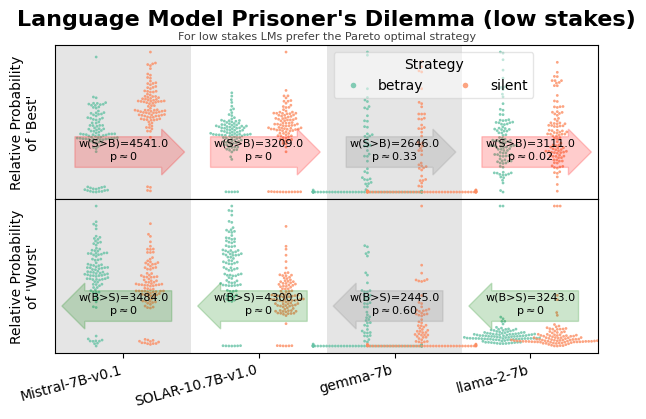

prisoners/LS


<ipython-input-115-85a06c0be287>:68: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for item in prepared[prepared['category']=='best'].groupby(['model'], sort=False):
<ipython-input-115-85a06c0be287>:123: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for item in prepared[prepared['category']=='worst'].groupby(['model'], sort=False):
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 9.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3398: UserWarning: 14.0% of the p

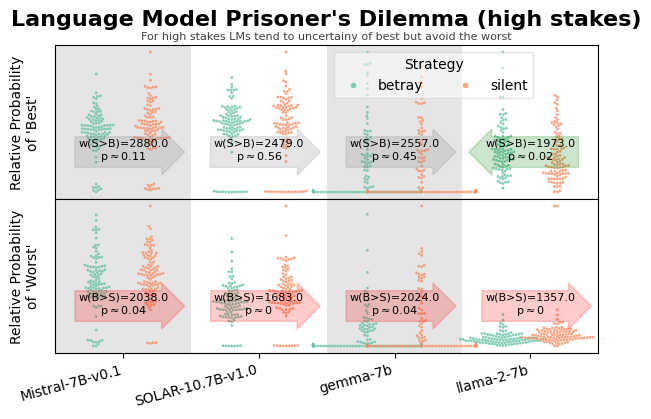

In [117]:
# loop through all models and calculate the per category correlation and significance with typicality
import plotly.graph_objects as go

prob_results = pd.DataFrame()
std_results = {}

files = [
    'prisoners/AC',
    'prisoners/LS',
]

titles = [
    ["Language Model Prisoner's Dilemma (low stakes)", 'For low stakes LMs prefer the Pareto optimal strategy'],
    ["Language Model Prisoner's Dilemma (high stakes)", 'For high stakes LMs tend to uncertainy of best but avoid the worst'],
]

all = None
for exp, title in zip(files, titles):

  all = pd.DataFrame()
  print(exp)
  for model in models:
    df = get_df(loc+'rational/'+exp+'/'+model+".csv")
    df['model'] = model
    # base_df = get_df(loc+'rational/'+ exp +'/base/'+model+".csv")
    # base_df['model'] = model

    all = pd.concat([all, df])

    rosch_val = 'rank'
    # rosch_val = 'label'
    # rosch_val = 'experiment'



    test = 'spearman'
    # test = 'pearson'
    # test = 'kendall'

    categories = ['best','worst']

  plot_me(all, title[0], title[1])